<a href="https://colab.research.google.com/github/dkant000/ML_PROJECT/blob/UrbansoundDetect/Final_ML_coursework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group 13 Machine Learning Project

---



Group Members: (add your name and student number here)

C1769595 - Kimberley Calleja <br>
C2092336 - Edvinas Goldstein <br>
C1987625 - Rujeko Chikwava <br>
DEV KANT <br>
C2107048 - Simranjeet Singh <br>
C1972348 - Qipeng Guo





## Set up

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from librosa import display
import librosa
import IPython.display
import glob
from scipy.stats import chi2_contingency, kruskal

#add more...

In [2]:
 #if you have uploaded the file to google drive:

# if you use Google Colab:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#create basedir path to where the urban sounds folder is saved in your drive
#leave it as a comment under your name to use next time

#Kimberley's file path:
#basedir = '/content/drive/MyDrive/Applied Machine Learning/Spring Semester/urban_sound/urban_sound/UrbanSound8K'

# Ed's file path:
# basedir = '/content/drive/MyDrive/urban_sound/urban_sound/UrbanSound8K'


# Simranjeet Singh
# basedir = '/content/drive/MyDrive/AppliedMachineLearning/SpringSemester/urban_sound/UrbanSound8K'

# dev
basedir = '/content/drive/MyDrive/data'
# Qipeng
# basedir='/content/drive/MyDrive/UrbanSounds'


In [4]:
# load csv for data analysis
# df = pd.read_csv(os.path.join(basedir, 'metadata/UrbanSound8K.csv'))

# DEV load csv
df = pd.read_csv(os.path.join(basedir, 'UrbanSound8K.csv'))

## Brief Overview (Info taken from the README file included in the dataset)

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: 
- air conditioner
- car horn, 
- children playing
- dog bark
- drilling
- engine idling
- gun shot
- jackhammer
- siren
- street music

Info on the csv file:

This file contains meta-data information about every audio file in the dataset. This includes:

* slice_file_name: 
The name of the audio file. The name takes the following format: [fsID]-[classID]-[occurrenceID]-[sliceID].wav, where:
    - [fsID] = the Freesound ID of the recording from which this excerpt (slice) is taken
    - [classID] = a numeric identifier of the sound class (see description of classID below for further details)
    - [occurrenceID] = a numeric identifier to distinguish different occurrences of the sound within the original recording
    - [sliceID] = a numeric identifier to distinguish different slices taken from the same occurrence

* fsID:
The Freesound ID of the recording from which this excerpt (slice) is taken

* start
The start time of the slice in the original Freesound recording

* end:
The end time of slice in the original Freesound recording

* salience:
A (subjective) salience rating of the sound. 1 = foreground, 2 = background.

* fold:
The fold number (1-10) to which this file has been allocated.

* classID: A numeric identifier of the sound class:
    - 0 = air_conditioner
    - 1 = car_horn
    - 2 = children_playing
    - 3 = dog_bark
    - 4 = drilling
    - 5 = engine_idling
    - 6 = gun_shot
    - 7 = jackhammer
    - 8 = siren
    - 9 = street_music

* class: the class name



## Data Analysis

This section contains:

- Visualisation of data (e.g. of some wav files)
- An overview of the csv file (e.g. number of files in each category)
- Statistics used to complement the descriptive analysis of the dataset
- Creation of .pkl files to use for pre-processing and model building

In [5]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [6]:
#check for data imbalances - does each category have a similar amount of data?
#could do bar chart of these values
#explain considerations for balancing or not balancing the data
df['classID'].value_counts()

7    1000
5    1000
4    1000
3    1000
2    1000
9    1000
0    1000
8     929
1     429
6     374
Name: classID, dtype: int64

In [7]:
df['fold'].value_counts()

4     990
5     936
3     925
2     888
1     873
7     838
10    837
6     823
9     816
8     806
Name: fold, dtype: int64

Text(0.5, 1.0, 'Number of samples for each class')

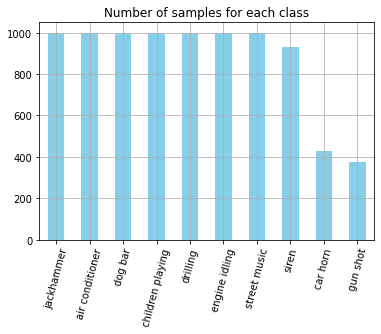

In [8]:
class_counts = df['class'].value_counts(sort=True)
class_counts.plot.bar(color = 'skyblue')

class_labels_temp = ["jackhammer", "air conditioner", "dog bar",
                "children playing", "drilling", "engine idling", "street music", 
                "siren", "car horn", "gun shot"]

plt.xticks(range(len(class_counts)), class_labels_temp)
plt.xticks(rotation=75)
plt.grid()
plt.title('Number of samples for each class')

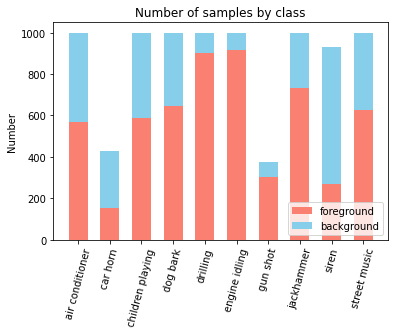

In [ ]:
class_labels = ["air conditioner", "car horn", "children playing", 
                "dog bark", "drilling", "engine idling", "gun shot", 
                "jackhammer", "siren", "street music"]
                
foreground = df[df['salience'] == 1]['classID'].value_counts().sort_index().values
background = df[df['salience'] == 2]['classID'].value_counts().sort_index().values

width = 0.6

fig, ax = plt.subplots()

ax.bar(class_labels, foreground, width,label='foreground', color = 'salmon')
ax.bar(class_labels, background, width,bottom=foreground,
       label='background', color='skyblue')
ax.set_ylabel('Number')
ax.set_title('Number of samples by class')
ax.legend(loc=4)
plt.xticks(rotation=75)

plt.show()

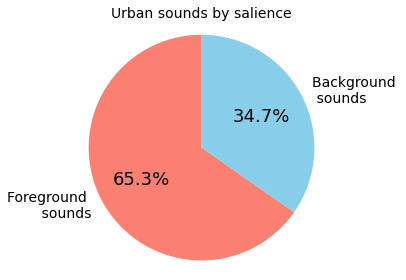

In [ ]:
labels = ['Foreground \n sounds', 'Background \n sounds']
fgval = df[df['salience'] == 1].shape[0]
bgval = df[df['salience'] == 2].shape[0]

fig, ax = plt.subplots()
patches, outsidetext, insidetext = ax.pie([fgval, bgval], colors = ['salmon', 'skyblue'], labels=labels, autopct='%1.1f%%', startangle=90)

for text in outsidetext:
    text.set_size(14)

for text in insidetext:
    text.set_size(18)
ax.axis('equal')
# ax.legend(loc= 4)
plt.title('Urban sounds by salience', fontsize= 14)
plt.tight_layout()
plt.show()

In [ ]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
df.info() # type information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


In [9]:
print('Metafile shape: ' + str(df.shape))
print('\n')
print('Checking for missing values in metafile:')
print(df.isnull().values.any()) # check for NaN values in metafile

Metafile shape: (8732, 8)


Checking for missing values in metafile:
False


In [ ]:
'''
Chi-square for independence
'''
# Chi-square for independence
                
foreground = df[df['salience'] == 1]['classID'].value_counts().sort_index().values
background = df[df['salience'] == 2]['classID'].value_counts().sort_index().values
table = [foreground, background]
stat, p, dof, expected = chi2_contingency(table)
print('P-value: {}' .format(p))

P-value: 7.695658468073049e-298


We can reject the null hypothesis with alpha = 0.05, as p-value < 0.05, meaning that salience and classes are dependent, there is association between variables. (but it is kind of obvious because there are way more foreground samples)

Ways of Visualising sounds (which are also the features we will use for the model):
- MFCC
- Melspectogram
- Chromagram
- Chroma cqt
- Chroma cens

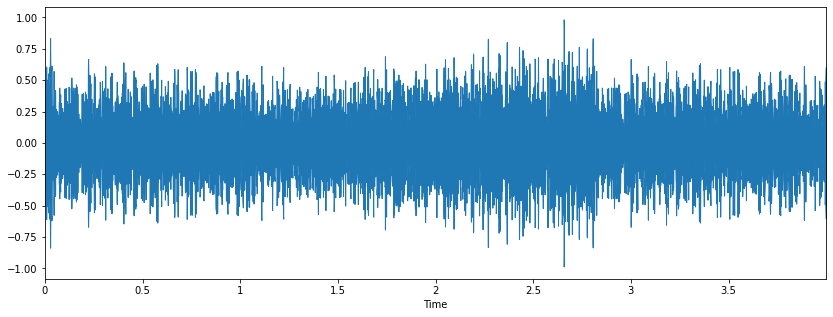

In [10]:
#e.g. to load audio file
#librosa.load returns an array (y here) and a sampling rate (sr - default 22050 = 22kHz)

y,sr=librosa.load(os.path.join(basedir, "audio/fold9/12812-5-0-0.wav"))
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)

IPython.display.Audio(y, rate=sr)

Using glob package to make list for each sound path. <br>
We can also do that for each fold separately.

In [ ]:
sounds = glob.glob(basedir + '/audio/*' + '/*.wav') # a list of paths for each sound
print(len(sounds)) # to make sure it the shape is of 8732 rows
# sounds

8732


### Creating .pkl files to compile information from Librosa

We can further read all files with Librosa and put sample rate and sample numbers into lists and create one dataframe with them. To avoid reading all sounds with Librosa, we can save created dataframe into pickle type files. It allows to read dataframe directly from pickle files whenever we want toinstead of reading with Librosa each time.

In [ ]:
# # DO NOT RUN THIS CODE BLOCK! 

# sr_list = []
# y_list = []
# name_list = []


# for no, file in enumerate(sounds):
#   if no%500 == 0:
#     print('currently at: ' + str(no))

#   y, sr = librosa.load(file)

#   name = file.split('/')[-1]


#   sr_list.append(sr)
#   y_list.append(y)
#   name_list.append(name)


# # creating dataframe with extracted sound information
# sounds_df = pd.DataFrame({
#     'name': name_list,
#     'sr': sr_list,
#      'y': y_list})

In [ ]:
# # DO NOT RUN THIS CODE BLOCK! 
# # joining metafile information with extracted sample info
# sounds_df = sounds_df.join(df.set_index('slice_file_name'), on='name')

In [ ]:
# # DO NOT RUN THIS CODE BLOCK! 
# sounds_df.tail()

In [ ]:
# # DO NOT RUN THIS CODE BLOCK! 
# # to put data frames into pickle files for later
# for i in np.arange(1,11):
#   sounds_df[sounds_df['fold'] == i].to_pickle('fold'+str(i)+'.pkl')
#   print(i)

This is how to read pickle files from Google Drive. Please upload to your drive instead of colab directly. If you have mounted drive with files, reading them wont take longer than a minute. The link for files: <br>
https://drive.google.com/file/d/1cLkb3GCUI-QU4RM5N0qH4M7ivesQQS9O/view?usp=sharing

In [ ]:
# adjust path individually for .pkl files

#Ed's file path
# pickle_files_path = '/content/drive/MyDrive/urban_sound/pickle_files/'


#Kimberley's file path
#pickle_files_path = '/content/drive/MyDrive/Applied Machine Learning/Spring Semester/UrbanSounds/'

#Simranjeet Singh
# pickle_files_path= "/content/drive/MyDrive/AppliedMachineLearning/SpringSemester/urban_sound/UrbanSound8K/UrbanSounds/"

# # DEV pkl file loc
pickle_files_path = '/content/drive/MyDrive/data/data_pkl/'

In [ ]:
'''
creates dataframe "df_urban_sounds" with information about samples
also creates 10 different dataframes "df_fold1, df_fold2, etc" for each fold
'''
appended_data = []
for i in np.arange(1,11):
  vars()['df_fold' + str(i)] = pd.read_pickle(pickle_files_path + 'fold' + str(i) + '.pkl')
  print(i)
  appended_data.append(vars()['df_fold' + str(i)])
df_urban_sounds = pd.concat(appended_data, ignore_index=True)

1
2
3
4
5
6
7
8
9
10


In [ ]:
'''
Created dataframe contains information about samples, where columns "sr" is sample rate and "y" is a list of recorded samples
'''
df_urban_sounds.head()

,name,sr,y,fsID,start,end,salience,fold,classID,class
0,101415-3-0-2.wav,22050,"[-0.00011783496, -0.00017157062, -0.0001774939...",101415,1.000000,5.000000,1,1,3,dog_bark
1,101415-3-0-8.wav,22050,"[0.23950581, 0.35340017, 0.29654667, 0.2917560...",101415,4.000000,8.000000,1,1,3,dog_bark
2,103074-7-0-2.wav,22050,"[0.0081740115, -0.0015046991, -0.0086963875, -...",103074,4.341279,8.341279,1,1,7,jackhammer
3,102842-3-1-0.wav,22050,"[0.007395301, 0.00981416, 0.00828659, 0.008712...",102842,113.061785,117.061785,2,1,3,dog_bark
4,101415-3-0-3.wav,22050,"[-0.0006034802, -0.0010423105, -0.0008373572, ...",101415,1.500000,5.500000,1,1,3,dog_bark


In [ ]:
# type(df_urban_sounds['y'])

In [ ]:
# example 1. using full "df_urban_sounds"
print('Sample name:')
print(df_urban_sounds.iloc[0]['name'])
print('\n Sample rate:')
print(df_urban_sounds.iloc[0]['sr'])
print('\n Number of samples:')
print(df_urban_sounds.iloc[0]['y'])

Sample name:
101415-3-0-2.wav

 Sample rate:
22050

 Number of samples:
[-0.00011783 -0.00017157 -0.00017749 ... -0.04598654 -0.04624664
 -0.05089863]


In [ ]:
# example 2. using "df_fold1"
print('Sample name:')
print(df_fold1.iloc[0]['name'])
print('\n Sample rate:')
print(df_fold1.iloc[0]['sr'])
print('\n Number of samples:')
print(df_fold1.iloc[0]['y'])

Sample name:
101415-3-0-2.wav

 Sample rate:
22050

 Number of samples:
[-0.00011783 -0.00017157 -0.00017749 ... -0.04598654 -0.04624664
 -0.05089863]


In [ ]:
# Example: how it is possible to get exact length of the samples by dividing frame rate and number of frames

# calcualte duration
duration_list = []
for i in range(df_urban_sounds.shape[0]):
  dur = len(df_urban_sounds.iloc[i]['y'])/df_urban_sounds.iloc[i]['sr']
  duration_list.append(dur)

# adding new column of lengths
df_urban_sounds['length'] = duration_list

df_urban_sounds.tail()

,name,sr,y,fsID,start,end,salience,fold,classID,class,length
8727,99192-4-0-53.wav,22050,"[0.059988726, 0.061065044, 0.16498338, 0.14804...",99192,26.5,30.5,1,10,4,drilling,4.0
8728,99192-4-0-55.wav,22050,"[0.01473959, 0.022773646, 0.05025508, 0.058404...",99192,27.5,31.5,1,10,4,drilling,4.0
8729,99192-4-0-54.wav,22050,"[0.005095922, 0.014739645, 0.011429922, -0.000...",99192,27.0,31.0,1,10,4,drilling,4.0
8730,99192-4-0-52.wav,22050,"[-0.008036119, -0.019243455, -0.013388598, 0.0...",99192,26.0,30.0,1,10,4,drilling,4.0
8731,99192-4-0-7.wav,22050,"[0.024699196, 0.0069064884, 0.03016094, 0.0363...",99192,3.5,7.5,1,10,4,drilling,4.0


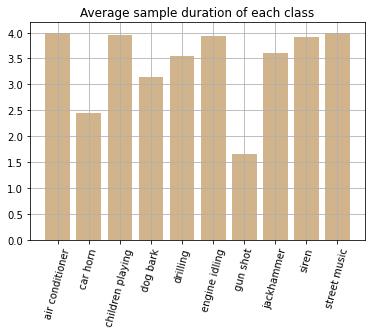

In [ ]:
# average duration of each class

avg_len = []
for i in np.arange(0,10):
  avg_dur = np.average(df_urban_sounds[df_urban_sounds['classID'] == i]['length'].values)
  avg_len.append(avg_dur)

# class labels in order
class_labels = ["air conditioner", "car horn", "children playing", 
                "dog bark", "drilling", "engine idling", "gun shot", 
                "jackhammer", "siren", "street music"]
# plotting
plt.xticks(range(len(avg_len)), class_labels)
plt.xticks(rotation=75)
plt.title('Average sample duration of each class')
plt.bar(range(len(avg_len)), avg_len, color='tan')
plt.grid()
plt.show()

In [ ]:
'''
Kruskal test
'''


for i in np.arange(0,10):
  vars()['cl' + str(i)]  = df_urban_sounds[df_urban_sounds['classID'] == i]['length'].values.tolist()

kruskal(cl0, cl1, cl2, cl3, cl4, cl5, cl6, cl7, cl8, cl9)

KruskalResult(statistic=3170.673555048203, pvalue=0.0)

Since p-value is less than alpha = 0.05, we can reject the null hypothesis and state that the median of sample lengths between classes is the same. There is significant difference between duration of the samples.

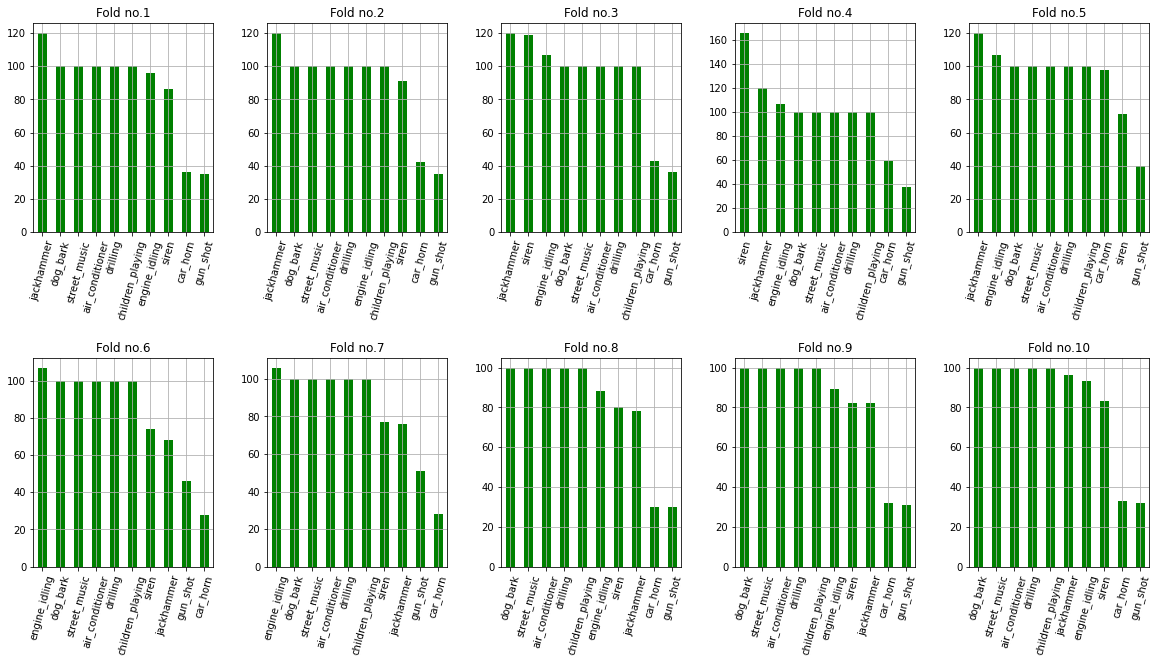

In [ ]:

'''
Each fold imbalance
'''
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.6, wspace=0.3)

for i in np.arange(1,11):
  ax = fig.add_subplot(2, 5, i)
  vars()['df_fold' + str(i)]['class'].value_counts(sort=True).plot.bar(color = 'g')
  plt.title('Fold no.' + str(i))
  plt.xticks(rotation=75)
  plt.grid()

plt.show()

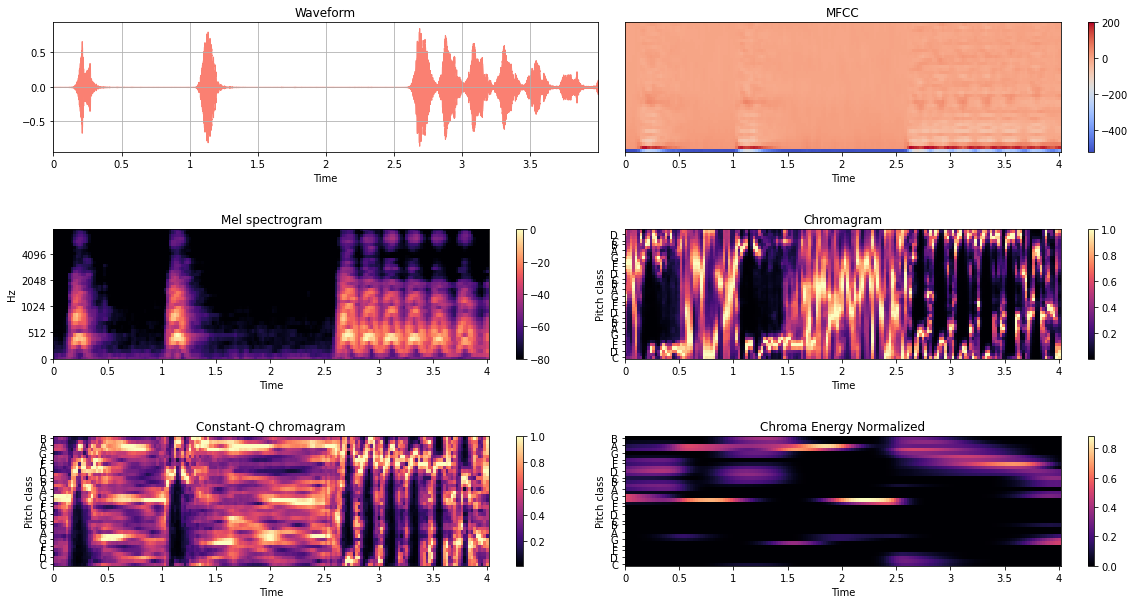

In [ ]:
'''
Audio sample visualisation
'''

# read
sr, y = df_fold1.iloc[0]['sr'], df_fold1.iloc[0]['y']

mfccs = librosa.feature.mfcc(y, sr, n_mfcc=40)
melspectrogram =librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40,fmax=8000)
chroma_stft=librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=40)
chroma_cq =librosa.feature.chroma_cqt(y=y, sr=sr,n_chroma=36)
chroma_cens =librosa.feature.chroma_cens(y=y, sr=sr,n_chroma=36)

# plot
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.6, wspace=0.05)

ax = fig.add_subplot(3, 2, 1)
librosa.display.waveplot(y, sr=sr, color='salmon')
plt.grid()
plt.title('Waveform')

ax = fig.add_subplot(3, 2, 2)
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')

ax = fig.add_subplot(3, 2, 3)
librosa.display.specshow(librosa.power_to_db(melspectrogram,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar()
plt.title('Mel spectrogram')


ax = fig.add_subplot(3, 2, 4)
librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')

ax = fig.add_subplot(3, 2, 5)
librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Constant-Q chromagram')

ax = fig.add_subplot(3, 2, 6)
librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chroma Energy Normalized')
plt.show()

## Data Preprocessing

We need to create a feature set of the wav files for our model to use and split into training/validation/test sets.
In the given example (https://github.com/AmritK10/Urban-Sound-Classification/blob/master/Urban_data_preprocess.ipynb), the features used are:

- MFCCs - Mel-frequency cepstral coefficients
- Melspectrogram
- Chromagram
- Constant-Q chromagram
- Chroma Energy Normalized (CENS)

Each of these features give data values about each sound (and therefore qualities that make each category recognisable) and can be used as input to train our models. We can use a loop to iterate over each file, and store these values (using numpy.vstack to compile all of these features for each sound) for that wav file along with the label. To calculate the feature values, we can use the corresponding librosa functions.

May also need to do some data balancing for 'car horn' and 'gunshot' which have fewer wav files (data augmentation maybe).

In [ ]:
# Example how it is possible to access metrics provided for any .wav sound sample

# It uses created dataframe from .pkl files

# information from "fold_1" dataframe.
sr, y = df_fold1.iloc[0]['sr'], df_fold1.iloc[0]['y']

# # metrics taken from GitHub link mentioned above
# mfccs = librosa.feature.mfcc(y, sr, n_mfcc=40) # MFCCs
# melspectrogram =librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40,fmax=8000) # Melspectogram
# chroma_stft=librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=40) # Chromagram
# chroma_cq =librosa.feature.chroma_cqt(y=y, sr=sr,n_chroma=36) # Constant-Q chromagram. n_chroma adjusted to 36
# chroma_cens =librosa.feature.chroma_cens(y=y, sr=sr,n_chroma=36) # Chroma Energy Normalized. n_chroma adjusted to 36

### 1. Data Augmentation

We have far fewer samples of 'car_horn' and 'gun_shot' so will perform some data augmentation to create more data on which to train our model. 

In [ ]:
#Data Augmentation

#several options for data augmentation - add white noise, adjust pitch, time shifting
#aim to keep the sounds recognisable (don't distort too much)
#used from https://www.kaggle.com/mpwolke/who-let-the-dogs-out-wav

def pitch(data):
    """
    Adjusts pitch.
    """
    sample_rate =  22050
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data


def white_noise(data):
    """
    Adding White Noise
    """
    noise_amp = 0.05*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data


In [ ]:
#example of pitch change

sr_car, y_car = df_urban_sounds.iloc[328]['sr'], df_urban_sounds.iloc[328]['y']       #car horn sound

#original sound
IPython.display.Audio(y_car, rate=sr_car)

In [ ]:
#car horn after pitch change

x = pitch(y_car)
IPython.display.Audio(x, rate=sr_car)

In [ ]:
#car horn after white noise added

x = white_noise(y_car)
IPython.display.Audio(x, rate=sr_car)

In [ ]:
def augmenter(df):
  """
  Adding White Noise and adjusting pitch - apply to dataframe column 'y'
  """
  df['y'] = df['y'].apply(white_noise)
  df['y'] = df['y'].apply(pitch)
  return df

In [ ]:
'''
Here we calculate weights for each fold. 
We want to ensure that the folds have a maintain a roughly even distribution of proportions of classes after augmentation
Focus will be on adding white noise to produce new samples of 'gun_shot' and 'car_horn' to fix the data imbalance.
Note that the names and times of these new sound files don't matter as they are not used in training the models.
'''
# number of samples
no_gs = df_urban_sounds['class'].value_counts()['gun_shot'] # 374
no_ch = df_urban_sounds['class'].value_counts()['car_horn'] # 429
no_s = df_urban_sounds['class'].value_counts()['siren'] # 929

# arrays of rows number which will be added to each fold
gsarr = []
charr = []

temp = df_urban_sounds[(df_urban_sounds['class'] != 'car_horn') & (df_urban_sounds['class'] != 'gun_shot')].copy()
for i in np.arange(1,9): # only 8 folds because we balance only training set
  avg = np.average(temp[temp['fold'] == i]['class'].value_counts())
  avg = int(round(avg))

  no1 = len(df_urban_sounds[(df_urban_sounds['fold'] == i) & (df_urban_sounds['class'] == 'gun_shot')])
  no2 = len(df_urban_sounds[(df_urban_sounds['fold'] == i) & (df_urban_sounds['class'] == 'car_horn')])

  if no1<avg:
    gsarr = np.append(gsarr, avg - no1).astype(int)
  if no2<avg:
    charr = np.append(charr, avg - no2).astype(int)

In [ ]:
gs_aug_df = pd.DataFrame()
ch_aug_df = pd.DataFrame()

# pick random row. "replace = True" allows to take the same row multiple times (we use that because there are more than 500 'missing' samples). 
#The changes are also random so it is highly unlikely that a change will be repeated.

for i in np.arange(1,9):
  gs_aug = df_urban_sounds[(df_urban_sounds['fold'] == i) & (df_urban_sounds['class'] == 'gun_shot')].sample(n=gsarr[i-1], replace = True)
  gs_aug_df = gs_aug_df.append(augmenter(gs_aug))

  ch_aug = df_urban_sounds[(df_urban_sounds['fold'] == i) & (df_urban_sounds['class'] == 'car_horn')].sample(n=charr[i-1], replace = True)
  ch_aug_df = ch_aug_df.append(augmenter(ch_aug))


#append the car_horn and gun_shot noises with white noise and changed pitch added to df_urban_sounds dataframe
df_urban_sounds = df_urban_sounds.append([gs_aug_df, ch_aug_df], ignore_index=True)

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]


In [ ]:
df_urban_sounds.tail() 
# 9659 rows, similar to what we would expect since fold9 and fold10 have imbalanced for 2 classes (so approx 10000-2*2*100)

,name,sr,y,fsID,start,end,salience,fold,classID,class,length
9654,71309-1-0-2.wav,22050,"[-0.0012649096596543978, 0.020642434302284383,...",71309,1.406025,5.406025,2,8,1,car_horn,4.000000
9655,71309-1-0-6.wav,22050,"[-0.03329663101633243, -0.08820203408370483, -...",71309,3.406025,7.406025,2,8,1,car_horn,4.000000
9656,71309-1-0-1.wav,22050,"[0.0017266054817884466, 0.00521415710007656, 0...",71309,0.906025,4.906025,2,8,1,car_horn,4.000000
9657,175856-1-2-0.wav,22050,"[0.0037795143092226985, -0.013134461087569932,...",175856,3.031496,4.156539,1,8,1,car_horn,1.125079
9658,71309-1-0-1.wav,22050,"[0.007089740042599054, 0.02569731628500726, 0....",71309,0.906025,4.906025,2,8,1,car_horn,4.000000


We can check the white noise and pitch changes were applied:

In [ ]:
#finding instances with the same name and listening to audio
df_urban_sounds[df_urban_sounds.name == '107090-1-1-0.wav']

,name,sr,y,fsID,start,end,salience,fold,classID,class,length
6275,107090-1-1-0.wav,22050,"[-0.0050713373, -0.02095482, -0.03342774, -0.0...",107090,29.715744,30.54502,2,8,1,car_horn,0.829297
9603,107090-1-1-0.wav,22050,"[-0.003805076285677791, -0.019731631844395848,...",107090,29.715744,30.54502,2,8,1,car_horn,0.829297
9612,107090-1-1-0.wav,22050,"[0.02009081538786674, -0.0553497600752158, -0....",107090,29.715744,30.54502,2,8,1,car_horn,0.829297
9641,107090-1-1-0.wav,22050,"[-0.0049741957656399115, -0.02702865413655594,...",107090,29.715744,30.54502,2,8,1,car_horn,0.829297


In [ ]:
sr_car, y_car = df_urban_sounds.iloc[6275]['sr'], df_urban_sounds.iloc[6275]['y']       #car horn sound with added white noise

IPython.display.Audio(y_car, rate=sr_car)

In [ ]:
sr_car, y_car = df_urban_sounds.iloc[9626]['sr'], df_urban_sounds.iloc[9626]['y']       #car horn sound with added white noise and pitch change

IPython.display.Audio(y_car, rate=sr_car)

In [ ]:
sr_car, y_car = df_urban_sounds.iloc[9657]['sr'], df_urban_sounds.iloc[9657]['y']       #car horn sound with added white noise and pitch change

IPython.display.Audio(y_car, rate=sr_car)

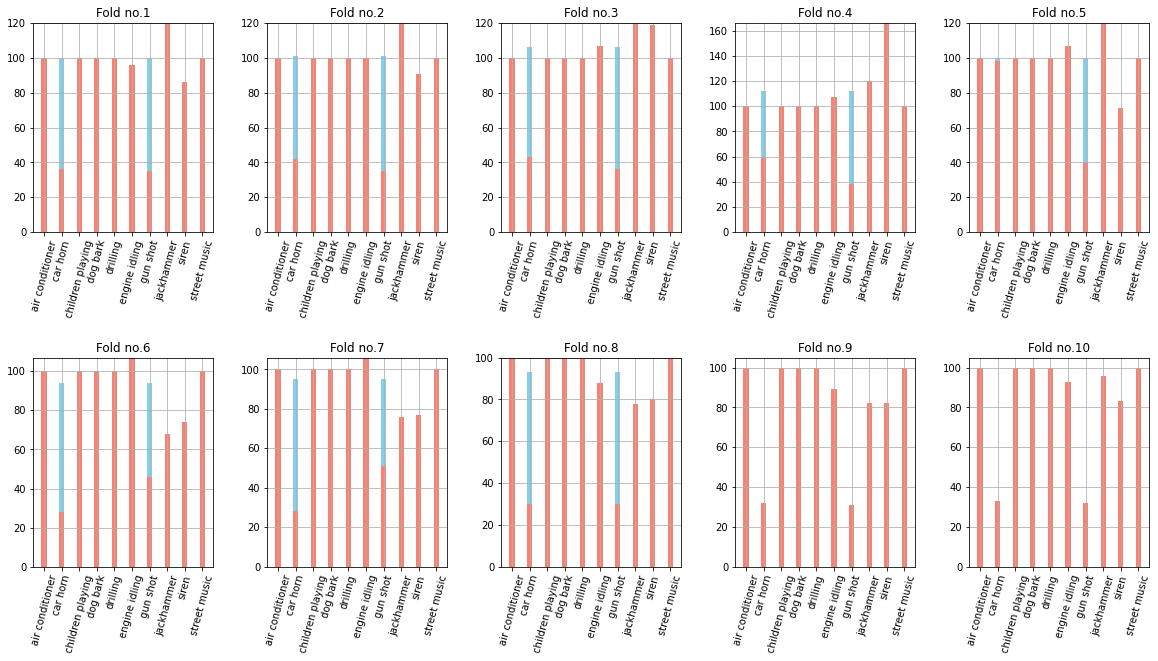

In [ ]:
'''
Plotting imbalanced folds with additional rows to balance them
'''
# labels sorted by classID
class_labels = ["air conditioner", "car horn", "children playing", 
                "dog bark", "drilling", "engine idling", "gun shot", 
                "jackhammer", "siren", "street music"]

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.6, wspace=0.3)

df_withoutWN = df_urban_sounds[:8732]
df_withWN = df_urban_sounds[8732:]

df_empty = pd.Series(data=np.repeat(0,8), index=np.array([0,2,3,4,5,7,8,9])) # for other 8 classes

width = 0.3

for i in np.arange(1,11):
  vals = df_withoutWN[df_withoutWN['fold'] == i]['classID'].value_counts().sort_index().values
  if i <= 8:
    vals2 = df_withWN[df_withWN['fold'] == i]['classID'].value_counts()
    vals2 = vals2.append(df_empty).sort_index().values

  ax = fig.add_subplot(2, 5, i)
  ax.bar(class_labels, vals, width, label='Before', color = 'salmon')
  if i <= 8:
    ax.bar(class_labels, vals2, width,bottom=vals, label='After', color='skyblue')

  plt.title('Fold no.' + str(i))
  plt.xticks(rotation=75)
  plt.grid()
  
plt.show()

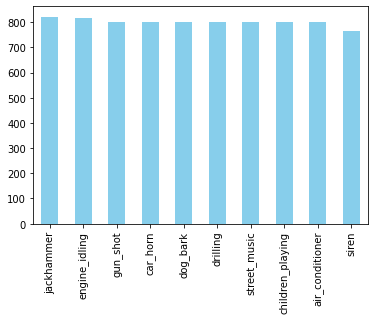

In [ ]:
# folds until 8
class_counts = df_urban_sounds[(df_urban_sounds['fold'] != 9) & (df_urban_sounds['fold'] != 10)]['class'].value_counts(sort=True)
class_counts.plot.bar(color = 'skyblue')

###  2. Creating Feature Set and splitting the data

In [ ]:
#go for approx 80/20 train/test split using folds (allocate folds 9 and 10 as test data)

In [ ]:
# # DO NOT RUN THIS CODE BLOCK! 

# x_train=[]
# x_test=[]
# y_train=[]
# y_test=[]


# #iterate over each row
# #for each row get features of the sound, and compile into single array
# #perform train test split - 80/20
# for index, row in tqdm(df_urban_sounds.iterrows()):

#     fold = df_urban_sounds.iloc[index]["fold"]
#     label= df_urban_sounds.iloc[index]['classID']
#     sr, y = df_urban_sounds.iloc[index]['sr'], df_urban_sounds.iloc[index]['y']

#     mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T, axis = 0) # MFCCs
#     melspectrogram =np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40,fmax=8000).T, axis = 0) # Melspectogram
#     chroma_stft= np.mean(librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=40).T, axis = 0) # Chromagram
#     chroma_cq =np.mean(librosa.feature.chroma_cqt(y=y, sr=sr,n_chroma=40, bins_per_octave=40).T, axis = 0) # Constant-Q chromagram. bins_per_octave adjusted to 40
#     chroma_cens =np.mean(librosa.feature.chroma_cens(y=y, sr=sr,n_chroma=40, bins_per_octave=40).T, axis = 0) # Chroma Energy Normalized. bins_per_octave adjusted to 40

#     #print(melspectrogram.shape,chroma_stft.shape,chroma_cq.shape,chroma_cens.shape,mfccs.shape)
#     features=np.reshape(np.vstack((mfccs,melspectrogram,chroma_stft,chroma_cq,chroma_cens)),(40,5))
#     if(fold != 9 and fold != 10):
#       x_train.append(features)
#       y_train.append(label)
#     else:
#       x_test.append(features)
#       y_test.append(label)

In [ ]:
# len(x_train)+len(x_test)

In [ ]:
# # DO NOT RUN THIS CODE BLOCK! 

# #Models require the training/test data to be in the form of arrays
# #convert from list to arrays

# x_train_array =np.array(x_train)
# x_test_array  =np.array(x_test)
# y_train_array =np.array(y_train)
# y_test_array  =np.array(y_test)
# print(x_train_array.shape,x_test_array.shape,y_train_array.shape,y_test_array.shape)

In [ ]:
# # DO NOT RUN THIS CODE BLOCK! 

# #reshaping into 2d to save in csv format so that we do not need to rerun the above cells
# x_train_2d=np.reshape(x_train_array,(x_train_array.shape[0],x_train_array.shape[1]*x_train_array.shape[2]))
# x_test_2d=np.reshape(x_test_array,(x_test_array.shape[0],x_test_array.shape[1]*x_test_array.shape[2]))
# x_train_2d.shape,x_test_2d.shape

In [ ]:
# # DO NOT RUN THIS CODE BLOCK! 

# #saving the csv file (Share with group so that they do not have to rerun the above code themselves)
# np.savetxt("train_data.csv", x_train_2d, delimiter=",")
# np.savetxt("test_data.csv",x_test_2d,delimiter=",")
# np.savetxt("train_labels.csv",y_train,delimiter=",")
# np.savetxt("test_labels.csv",y_test,delimiter=",")

The train and test data is saved into csv files so that the above code does not have to be rerun. Here is the link to the files for you to download to your Drive:

https://drive.google.com/drive/folders/1CJ2jS9j4VWNv7f79nNl8lhIcErMAyT0o?usp=sharing





## Model Implementation & Optimisation



We need to develop several different models for comparison. Some variations of our own i.e. trialling different layers. Also use at least one pre-made model(e.g. AlexNet) for comparison, and perhaps another from a literature review that has been tried before on this dataset.

In [ ]:
#Leave your file path here so you can load the train/test data

#Kimberley's file path:
# traintest_dir = '/content/drive/MyDrive/Applied Machine Learning/Spring Semester/train_test/'


#Ed's file path:
# traintest_dir = '/content/drive/MyDrive/urban_sound/datasets/'

#Simranjeeet Singh
# traintest_dir= '/content/drive/MyDrive/AppliedMachineLearning/SpringSemester/train_test/'

#DEV
traintest_dir = '/content/drive/MyDrive/data/raw_data/'

In [ ]:
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import MinMaxScaler

x_train = pd.read_csv(os.path.join(traintest_dir, 'train_data.csv'), header= None)
y_train = pd.read_csv(os.path.join(traintest_dir, 'train_labels.csv'), header = None)
x_test = pd.read_csv(os.path.join(traintest_dir, 'test_data.csv'), header = None)
y_test = pd.read_csv(os.path.join(traintest_dir, 'test_labels.csv'), header = None)

# fit scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)
# y_train=scaler.transform(y_train)

#convert back to numpy arrays 
# x_train = x_train.to_numpy()
# y_train = y_train.to_numpy()

# x_test = x_test.to_numpy()
# y_test = y_test.to_numpy()


y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(8006, 200) (8006, 10) (1653, 200) (1653, 10)


In [ ]:
# x_train=x_train.reshape(x_train.shape[0], 40, 5)
# print(x_train.shape)

In [ ]:
# All libraries
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from keras import Sequential
from keras.layers import Dense,Dropout,Activation
from keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")
from mlxtend.plotting import plot_decision_regions
from matplotlib.colors import ListedColormap
import keras
from keras import Sequential
from keras.layers import Dense,Dropout,Activation, Conv2D, Conv1D
from keras.layers import MaxPooling2D, Flatten, LSTM, TimeDistributed, Reshape


# Our models

We aim to have reproducible results, thus we set seed for random variables. The idea and code was implemented from: <br>
https://stackoverflow.com/questions/48631576/reproducible-results-using-keras-with-tensorflow-backend

In [ ]:
# Seed value (can actually be different for each attribution step)
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value) # tensorflow 2.x
# tf.set_random_seed(seed_value) # tensorflow 1.x

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf =  tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

**For model evaluation**

In [ ]:
def my_results(y_true, y_pred):
  preds = np.zeros_like(y_pred)
  preds[np.arange(len(y_pred)), y_pred.argmax(1)] = 1
  matrix = confusion_matrix(y_true.argmax(axis=1), preds.argmax(axis=1))

  # accuracy
  acc = accuracy_score(y_true, preds)

  # recal, precision for each class
  recall_classes = recall = np.diag(matrix) / np.sum(matrix, axis = 1)
  precision_classes = precision = np.diag(matrix) / np.sum(matrix, axis = 0)

  # micro. precision and recall should be the same!
  f1_micro = f1_score(y_test, preds, average="micro")
  precision_micro = precision_score(y_test, preds, average="micro")
  recall_micro = recall_score(y_test, preds, average="micro")

  # macro
  f1_macro = f1_score(y_test, preds, average="macro")
  precision_macro = precision_score(y_test, preds, average="macro")
  recall_macro = recall_score(y_test, preds, average="macro")

  # writing to df
  res = {'Precision': [precision_micro, precision_macro], 'Recall': [recall_micro, recall_micro], 'F1-score': [f1_micro, f1_macro]}
  mydf = pd.DataFrame(data=res, index=['Micro', 'Macro'])

  return mydf, acc, recall_classes, precision_classes


# Simple CNN

In [ ]:
tf.random.set_seed(seed_value) # to get reproducible results

model=Sequential()

###first layer
model.add(Dense(100,input_shape=(None,200)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 100)         20100     
_________________________________________________________________
activation (Activation)      (None, None, 100)         0         
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 200)         20200     
_________________________________________________________________
activation_1 (Activation)    (None, None, 200)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 100)         2

In [ ]:
#compiling
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#fitting
history = model.fit(x_train,y_train,epochs=30,validation_data=(x_test,y_test),batch_size=25)

Epoch 1/30
321/321 [==============================] - 1s 3ms/step - loss: 1.0790 - accuracy: 0.6481 - val_loss: 1.3752 - val_accuracy: 0.5759
Epoch 2/30
321/321 [==============================] - 1s 3ms/step - loss: 1.0416 - accuracy: 0.6610 - val_loss: 1.4509 - val_accuracy: 0.5668
Epoch 3/30
321/321 [==============================] - 1s 2ms/step - loss: 1.0204 - accuracy: 0.6754 - val_loss: 1.3595 - val_accuracy: 0.5929
Epoch 4/30
321/321 [==============================] - 1s 3ms/step - loss: 0.9926 - accuracy: 0.6830 - val_loss: 1.4225 - val_accuracy: 0.5796
Epoch 5/30
321/321 [==============================] - 1s 2ms/step - loss: 0.9525 - accuracy: 0.6974 - val_loss: 1.4605 - val_accuracy: 0.5711
Epoch 6/30
321/321 [==============================] - 1s 3ms/step - loss: 0.9685 - accuracy: 0.6899 - val_loss: 1.3028 - val_accuracy: 0.5983
Epoch 7/30
321/321 [==============================] - 1s 2ms/step - loss: 0.9484 - accuracy: 0.6994 - val_loss: 1.2886 - val_accuracy: 0.6001
Epoch 

In [ ]:
# model.predict(x_train)[0]

# plot_decision_regions(x_test[0:10],y_test[0].astype(np.integer), clf = model, legend=10)
# plt.show()

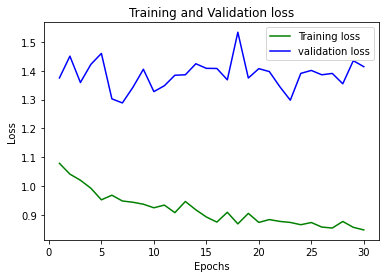

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

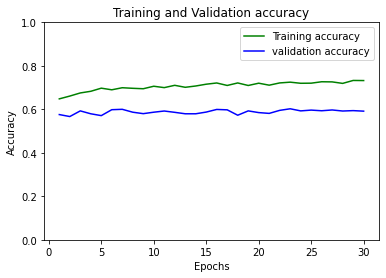

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
# predictions
y_pred = model.predict(x_test)

# metrics
dfresults, acc, recall_classes, precision_classes = my_results(y_test, y_pred)

In [ ]:
print('***********************************************')
print(dfresults)
print('***********************************************\n')
print('Accuracy: {}'.format(acc))
print('***********************************************\n')
print('Precision by class: {}'.format(precision_classes))
print('\n')
print('Recall by class: {}'.format(recall_classes))

***********************************************
       Precision    Recall  F1-score
Micro   0.591652  0.591652  0.591652
Macro   0.619232  0.591652  0.608740
***********************************************

Accuracy: 0.5916515426497277
***********************************************

Precision by class: [0.76530612 0.85245902 0.45247148 0.72413793 0.35       0.74157303
 0.52747253 0.50877193 0.64141414 0.62871287]


Recall by class: [0.375      0.8        0.595      0.63       0.28       0.72527473
 0.76190476 0.65168539 0.76969697 0.635     ]


##### Hyperparameter Tuning

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import GridSearchCV 
from keras.wrappers.scikit_learn import KerasClassifier

def DL_Model(activation= "rlue", optimizer='Adam'):
    model = Sequential()
    model.add(Dense(100, input_shape= (None,200), activation= activation))
    model.add(Dropout(0.5))
    model.add(Dense(200, activation= activation))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation= activation))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])
    return model

# Definying grid parameters
activation = ['softmax', 'relu', 'tanh', 'sigmoid', 'linear']
# neurons = [100, 125, 150, 200, 225, 250]
optimizer = ['SGD', 'Adam', 'Adamax']
param_grid = dict(activation = activation, optimizer = optimizer)

clf = KerasClassifier(build_fn= DL_Model, epochs=30, batch_size=50, verbose= 0)

model = GridSearchCV(estimator= clf, param_grid=param_grid, n_jobs=-1)
model.fit(x_train,y_train)

print("Max Accuracy Registred: {} using {}".format(round(model.best_score_,3), 
                                                   model.best_params_))

Max Accuracy Registred: 0.534 using {'activation': 'relu', 'optimizer': 'Adam'}


# Complex CNN

In [ ]:
# temporary reshaping for better understanding
Xtr = x_train.reshape(x_train.shape[0], 40, 5) # to differentiate 5 features
Xte = x_test.reshape(x_test.shape[0], 40, 5)

In [ ]:
# input_shape = (Xtr.shape[1], Xtr.shape[2], 1)
XtrCNN = Xtr.reshape(Xtr.shape[0], Xtr.shape[1], Xtr.shape[2], 1)
XteCNN = Xte.reshape(Xte.shape[0], Xte.shape[1], Xte.shape[2], 1)

print(XtrCNN.shape, Xte.shape, y_train.shape, y_test.shape)

(8006, 40, 5, 1) (1653, 40, 5) (8006, 10) (1653, 10)


In [ ]:
tf.random.set_seed(seed_value) # to get reproducible results

# forming model
model=Sequential()

#building the model
model.add(Conv2D(64, kernel_size = 5, strides=(1, 1), activation="relu", 
                 padding="same", input_shape=(XtrCNN.shape[1], XtrCNN.shape[2], 1)))
model.add(MaxPooling2D())
model.add(Conv2D(64, kernel_size = 5, activation="relu", padding="same"))
# model.add(MaxPooling2D())
model.add(Dropout(0.3))
model.add(Conv2D(64, kernel_size = 5, activation="relu", padding="same"))
# model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(units=700,activation='relu'))
model.add(Dense(units=600,activation='relu'))
model.add(Dense(units=500,activation='relu'))
model.add(Dense(units=400,activation='relu'))
model.add(Dense(units=10,activation='softmax'))

#compiling
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 40, 5, 64)         1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 2, 64)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 2, 64)         102464    
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 2, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 2, 64)         102464    
_________________________________________________________________
dropout_6 (Dropout)          (None, 20, 2, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2560)             

In [ ]:
#fitting
history = model.fit(XtrCNN,y_train,epochs=30,validation_data=(XteCNN, y_test), batch_size=30)

Epoch 1/30
267/267 [==============================] - 31s 114ms/step - loss: 2.0457 - accuracy: 0.2210 - val_loss: 1.6692 - val_accuracy: 0.3291
Epoch 2/30
267/267 [==============================] - 29s 108ms/step - loss: 1.3028 - accuracy: 0.5287 - val_loss: 1.3005 - val_accuracy: 0.5451
Epoch 3/30
267/267 [==============================] - 29s 109ms/step - loss: 0.9877 - accuracy: 0.6563 - val_loss: 1.4293 - val_accuracy: 0.5354
Epoch 4/30
267/267 [==============================] - 29s 109ms/step - loss: 0.8026 - accuracy: 0.7267 - val_loss: 1.3080 - val_accuracy: 0.6177
Epoch 5/30
267/267 [==============================] - 29s 109ms/step - loss: 0.6128 - accuracy: 0.7943 - val_loss: 1.5505 - val_accuracy: 0.5711
Epoch 6/30
267/267 [==============================] - 28s 107ms/step - loss: 0.5650 - accuracy: 0.8120 - val_loss: 1.3566 - val_accuracy: 0.6509
Epoch 7/30
267/267 [==============================] - 29s 108ms/step - loss: 0.4625 - accuracy: 0.8470 - val_loss: 1.3204 - val_ac

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='Validation loss')

plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
loss_train = history.history['categorical_accuracy']
loss_val = history.history['val_categorical_accuracy']

plt.plot(loss_train, 'g', label='Training accuracy')
plt.plot(loss_val, 'b', label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Published CNN

**Brief explanation** <br>
CNN uses a bit different shape transformation thus additional steps are required.

In [ ]:
tf.random.set_seed(seed_value) # to get reproducible results

#forming model
model=Sequential()

#building the model
model.add(Conv2D(64, kernel_size = 5, strides=(1, 1), activation="relu", 
                 padding="same", input_shape=(XtrCNN.shape[1], XtrCNN.shape[2], 1)))
model.add(MaxPooling2D())
model.add(Conv2D(64, kernel_size = 5, activation="relu", padding="same"))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=512,activation='relu'))
model.add(Dense(units=10,activation='softmax'))

#compiling
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 5, 64)         1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 2, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 2, 64)         102464    
_________________________________________________________________
dropout_6 (Dropout)          (None, 20, 2, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2560)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               655616    
_________________________________________________________________
dense_9 (Dense)              (None, 512)              

In [ ]:
#fitting
history = model.fit(XtrCNN,y_train,epochs=30,validation_data=(XteCNN, y_test), batch_size=30)

Epoch 1/30
267/267 [==============================] - 10s 33ms/step - loss: 1.8703 - accuracy: 0.3060 - val_loss: 1.3593 - val_accuracy: 0.5523
Epoch 2/30
267/267 [==============================] - 8s 30ms/step - loss: 0.9414 - accuracy: 0.6751 - val_loss: 1.2963 - val_accuracy: 0.6019
Epoch 3/30
267/267 [==============================] - 8s 30ms/step - loss: 0.6300 - accuracy: 0.7916 - val_loss: 1.3976 - val_accuracy: 0.6019
Epoch 4/30
267/267 [==============================] - 8s 30ms/step - loss: 0.4938 - accuracy: 0.8370 - val_loss: 1.2064 - val_accuracy: 0.6497
Epoch 5/30
267/267 [==============================] - 8s 30ms/step - loss: 0.3763 - accuracy: 0.8755 - val_loss: 1.5325 - val_accuracy: 0.6050
Epoch 6/30
267/267 [==============================] - 8s 30ms/step - loss: 0.2933 - accuracy: 0.9020 - val_loss: 1.4657 - val_accuracy: 0.6661
Epoch 7/30
267/267 [==============================] - 8s 30ms/step - loss: 0.2629 - accuracy: 0.9116 - val_loss: 1.6853 - val_accuracy: 0.615

In [ ]:
# yhat_train = model.predict(XtrCNN) # predictions train
# yhat_test = model.predict(XteCNN) # predictions test
model.evaluate(XteCNN, y_test)

52/52 [==============================] - 0s 9ms/step - loss: 2.6159 - accuracy: 0.6709


[2.6158955097198486, 0.6709014177322388]

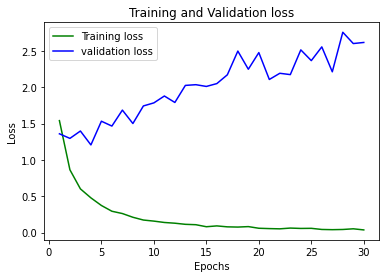

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

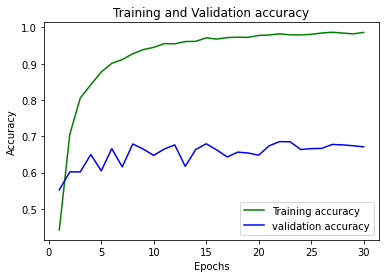

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# predictions
y_pred = model.predict(XteCNN)

# metrics
dfresults, acc, recall_classes, precision_classes = my_results(y_test, y_pred)

In [ ]:
print('***********************************************')
print(dfresults)
print('***********************************************\n')
print('Accuracy: {}'.format(acc))
print('***********************************************\n')
print('Precision by class: {}'.format(precision_classes))
print('\n')
print('Recall by class: {}'.format(recall_classes))

***********************************************
       Precision    Recall  F1-score
Micro   0.670901  0.670901  0.670901
Macro   0.698704  0.670901  0.686302
***********************************************

Accuracy: 0.6709013914095584
***********************************************

Precision by class: [0.83064516 0.75342466 0.70050761 0.66504854 0.45327103 0.93181818
 0.74603175 0.51960784 0.72131148 0.66536965]


Recall by class: [0.515      0.84615385 0.69       0.685      0.485      0.67582418
 0.74603175 0.59550562 0.8        0.855     ]


**note**: we probably should delete the following 'model behaviour ...' part

In [ ]:
tf.random.set_seed(seed_value) # to get reproducible results


In [ ]:
# history = model.fit(XtrCNN,y_train,epochs=30,validation_split=0.1, batch_size=40,)

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.5,1)
plt.legend()
plt.show()

In [ ]:
history = model.fit(XtrCNN,y_train,epochs=30,validation_data=(XteCNN,y_test), batch_size=40)

In [ ]:
# foo = np.zeros_like(yhat_train)
# foo[np.arange(len(yhat_train)), yhat_train.argmax(1)] = 1
# print('If arrays are equal that means there is a mistake. Should be False:')
# print(np.array_equal(y_train, foo))
# print('Accuracy of training set: ')
# print((y_train == foo).all(axis=1).sum()/len(y_train))

# print('\n')

# foo = np.zeros_like(yhat_test)
# foo[np.arange(len(yhat_test)), yhat_test.argmax(1)] = 1
# print('If arrays are equal that means there is a mistake. Should be False:')
# print(np.array_equal(y_test, foo))
# print('Accuracy of validation set: ')
# print((y_test == foo).all(axis=1).sum()/len(y_test))

**Fixing overfitting of published CNN**

# Published CNN (hat)

In [ ]:
'''
Cnn model with increased dropout and reduced learning rate as an attempt
to regulate overfitting
'''

tf.random.set_seed(seed_value) # to get reproducible results

#forming model
model=Sequential()

#building the model
model.add(Conv2D(64, kernel_size = 5, strides=(1, 1), activation="relu", 
                 padding="same", input_shape=(XtrCNN.shape[1], XtrCNN.shape[2], 1)))
model.add(MaxPooling2D())
model.add(Conv2D(64, kernel_size = 5, activation="relu", padding="same"))
model.add(Dropout(0.4)) # increasing dropout: 0.3 >> 0.4

model.add(Flatten())
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=512,activation='relu'))
model.add(Dense(units=10,activation='softmax'))

#compiling
opt = Adam(lr = 0.0008) # lowering learning rate: 0.001 >> 0.0008
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [ ]:
#fitting
history = model.fit(XtrCNN,y_train,epochs=30, validation_data=(XteCNN, y_test), batch_size=50)


Epoch 1/30
161/161 [==============================] - 8s 49ms/step - loss: 1.9421 - categorical_accuracy: 0.2790 - val_loss: 1.4985 - val_categorical_accuracy: 0.4561
Epoch 2/30
161/161 [==============================] - 8s 48ms/step - loss: 1.1425 - categorical_accuracy: 0.6068 - val_loss: 1.4094 - val_categorical_accuracy: 0.5547
Epoch 3/30
161/161 [==============================] - 8s 48ms/step - loss: 0.8534 - categorical_accuracy: 0.7232 - val_loss: 1.2528 - val_categorical_accuracy: 0.6177
Epoch 4/30
161/161 [==============================] - 8s 48ms/step - loss: 0.6539 - categorical_accuracy: 0.7865 - val_loss: 1.2414 - val_categorical_accuracy: 0.6388
Epoch 5/30
161/161 [==============================] - 8s 48ms/step - loss: 0.5190 - categorical_accuracy: 0.8318 - val_loss: 1.4383 - val_categorical_accuracy: 0.5717
Epoch 6/30
161/161 [==============================] - 8s 47ms/step - loss: 0.4685 - categorical_accuracy: 0.8425 - val_loss: 1.2464 - val_categorical_accuracy: 0.651

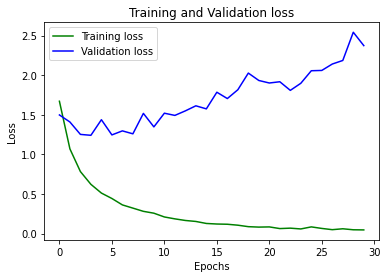

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='Validation loss')

plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

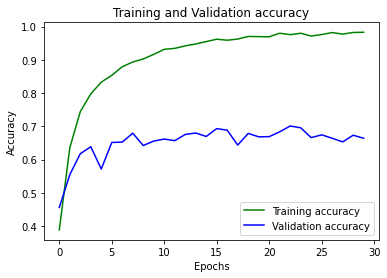

In [ ]:
loss_train = history.history['categorical_accuracy']
loss_val = history.history['val_categorical_accuracy']

plt.plot(loss_train, 'g', label='Training accuracy')
plt.plot(loss_val, 'b', label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# predictions
y_pred = model.predict(XteCNN)

# metrics
dfresults, acc, recall_classes, precision_classes = my_results(y_test, y_pred)

In [ ]:
print('***********************************************')
print(dfresults)
print('***********************************************\n')
print('Accuracy: {}'.format(acc))
print('***********************************************\n')
print('Precision by class: {}'.format(precision_classes))
print('\n')
print('Recall by class: {}'.format(recall_classes))

***********************************************
       Precision    Recall  F1-score
Micro   0.664247  0.664247  0.664247
Macro   0.700722  0.664247  0.674222
***********************************************

Accuracy: 0.6642468239564429
***********************************************

Precision by class: [0.8902439  0.79710145 0.70967742 0.63348416 0.43523316 0.9137931
 0.65333333 0.55241935 0.77358491 0.64835165]


Recall by class: [0.365      0.84615385 0.77       0.7        0.42       0.58241758
 0.77777778 0.76966292 0.74545455 0.885     ]


#### Published LSTM

This model is based upon the model developed in a publication by Das et al. (2020). 

-	We have used 2 LSTM layers with 128 hidden units in each. The layer requires output as a 3D array. First layer is provided with input of (20,5). Also, a dropout is used to avoid overfitting as much, with a value of 0.3.
-	In time distributed layer, the size of input for first layer is 128 with 256 number of nodes. For second layer, input size is 256 and 512 number of nodes. We have used ReLU activation function for both layers.
-	Output of time distributed dense layer (3D output) becomes input for flatten layer and the output is then passed to the last dense layer.
-	The outputs received from previous flatten layer are feed by dense layer to all 10 hidden layer neurons. At this layer we have used softmax activation function that gives output in terms of discrete probability distribution. 


In [ ]:
no_feats = 5

In [ ]:
XtrLSTM = x_train.reshape(x_train.shape[0], int(x_train.shape[1]/no_feats), no_feats) # (None, 40, 5)
XteLSTM = x_test.reshape(x_test.shape[0], int(x_test.shape[1]/no_feats), no_feats)

In [ ]:
XtrLSTM.shape

(8006, 40, 5)

In [ ]:
tf.random.set_seed(seed_value) # to get reproducible results

model = Sequential()

model.add(LSTM(128, return_sequences=True, input_shape=(40, 5)))
model.add(Dropout(0.3))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(TimeDistributed(Dense(256,  activation="relu")))
model.add(TimeDistributed(Dense(512, activation="relu")))

model.add(Flatten())
model.add(Dense(10,activation='softmax'))

#compiling
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(XtrLSTM, y_train, validation_data=(XteLSTM, y_test), epochs=30, batch_size=50)

Epoch 1/30
161/161 [==============================] - 25s 131ms/step - loss: 1.9961 - accuracy: 0.2481 - val_loss: 1.8964 - val_accuracy: 0.3085
Epoch 2/30
161/161 [==============================] - 20s 127ms/step - loss: 1.3879 - accuracy: 0.5216 - val_loss: 1.5483 - val_accuracy: 0.4374
Epoch 3/30
161/161 [==============================] - 21s 128ms/step - loss: 1.1373 - accuracy: 0.6168 - val_loss: 1.4260 - val_accuracy: 0.5547
Epoch 4/30
161/161 [==============================] - 21s 128ms/step - loss: 0.9663 - accuracy: 0.6690 - val_loss: 1.3417 - val_accuracy: 0.6062
Epoch 5/30
161/161 [==============================] - 21s 128ms/step - loss: 0.7610 - accuracy: 0.7493 - val_loss: 1.3978 - val_accuracy: 0.5487
Epoch 6/30
161/161 [==============================] - 21s 128ms/step - loss: 0.6876 - accuracy: 0.7766 - val_loss: 1.4519 - val_accuracy: 0.5826
Epoch 7/30
161/161 [==============================] - 21s 128ms/step - loss: 0.5955 - accuracy: 0.8025 - val_loss: 1.4178 - val_ac

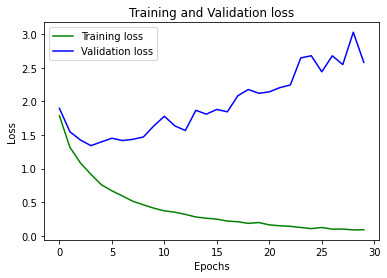

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='Validation loss')

plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

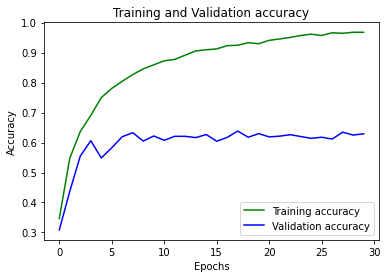

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']

plt.plot(loss_train, 'g', label='Training accuracy')
plt.plot(loss_val, 'b', label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# predictions
y_pred = model.predict(XteLSTM)

# metrics
dfresults, acc, recall_classes, precision_classes = my_results(y_test, y_pred)

In [ ]:
print('***********************************************')
print(dfresults)
print('***********************************************\n')
print('Accuracy: {}'.format(acc))
print('***********************************************\n')
print('Precision by class: {}'.format(precision_classes))
print('\n')
print('Recall by class: {}'.format(recall_classes))

***********************************************
       Precision    Recall  F1-score
Micro   0.629159  0.629159  0.629159
Macro   0.635989  0.629159  0.621296
***********************************************

Accuracy: 0.6291591046581972
***********************************************

Precision by class: [0.75862069 0.48113208 0.55555556 0.53781513 0.53888889 0.86524823
 0.546875   0.66842105 0.74213836 0.66519824]


Recall by class: [0.33       0.78461538 0.725      0.64       0.485      0.67032967
 0.55555556 0.71348315 0.71515152 0.755     ]


# Published LSTM (hat)

In [ ]:
'''
LSTM model with increased dropout and reduced learning rate as an attempt
to regulate overfitting
unfinished
'''

tf.random.set_seed(seed_value) # to get reproducible results

model = Sequential()

model.add(LSTM(64, return_sequences=True, input_shape=(40, 5))) # reducing
model.add(Dropout(0.3))
model.add(LSTM(128, return_sequences=True))

model.add(TimeDistributed(Dense(256,  activation="relu")))
model.add(TimeDistributed(Dense(512, activation="relu")))

model.add(Flatten())
model.add(Dense(10,activation='softmax'))

#compiling
opt = Adam(lr = 0.0008) # lowering learning rate
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#fitting
history = model.fit(XtrLSTM, y_train,epochs=30, validation_data=(XteLSTM, y_test), batch_size=50)

Epoch 1/30
161/161 [==============================] - 19s 100ms/step - loss: 1.9801 - accuracy: 0.2622 - val_loss: 1.8446 - val_accuracy: 0.3479
Epoch 2/30
161/161 [==============================] - 16s 100ms/step - loss: 1.4176 - accuracy: 0.5062 - val_loss: 1.6012 - val_accuracy: 0.4446
Epoch 3/30
161/161 [==============================] - 16s 98ms/step - loss: 1.1981 - accuracy: 0.5877 - val_loss: 1.4743 - val_accuracy: 0.5203
Epoch 4/30
161/161 [==============================] - 16s 98ms/step - loss: 1.0195 - accuracy: 0.6496 - val_loss: 1.4341 - val_accuracy: 0.5608
Epoch 5/30
161/161 [==============================] - 16s 99ms/step - loss: 0.8199 - accuracy: 0.7202 - val_loss: 1.5163 - val_accuracy: 0.5221
Epoch 6/30
161/161 [==============================] - 16s 99ms/step - loss: 0.7337 - accuracy: 0.7585 - val_loss: 1.5257 - val_accuracy: 0.5675
Epoch 7/30
161/161 [==============================] - 16s 97ms/step - loss: 0.6489 - accuracy: 0.7823 - val_loss: 1.4974 - val_accurac

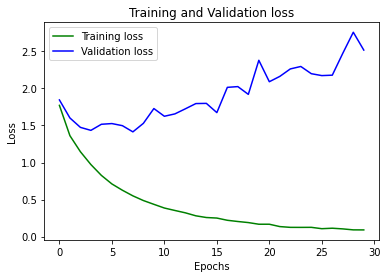

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='Validation loss')

plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

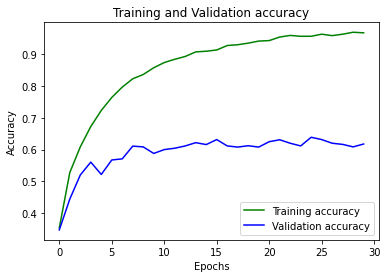

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']

plt.plot(loss_train, 'g', label='Training accuracy')
plt.plot(loss_val, 'b', label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# predictions
y_pred = model.predict(XteLSTM)

# metrics
dfresults, acc, recall_classes, precision_classes = my_results(y_test, y_pred)

In [ ]:
print('***********************************************')
print(dfresults)
print('***********************************************\n')
print('Accuracy: {}'.format(acc))
print('***********************************************\n')
print('Precision by class: {}'.format(precision_classes))
print('\n')
print('Recall by class: {}'.format(recall_classes))

***

***

In [ ]:
from tensorflow.keras.layers import Bidirectional, LSTM
model = Sequential()
model.add(LSTM(
        256,
        input_shape=(40,5),
        return_sequences=True
    ))
model.add(Dropout(0.3))
model.add(LSTM(512,return_sequences=True))
model.add(Dropout(0.3))
# model.add(LSTM(256,))
# model.add(Dense(256))
# model.add(Dropout(0.3))
model.add(TimeDistributed(Dense(256,  activation="relu")))
model.add(TimeDistributed(Dense(512, activation="relu")))
model.add(Flatten())
model.add(Dense(10))

model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='ADAM',metrics='accuracy')

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from tensorflow import keras
# filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
# checkpoint = ModelCheckpoint(
#     filepath, monitor='loss', 
#     verbose=0,        
#     save_best_only=True,        
#     mode='min'
# )    
# callbacks_list = [checkpoint]     
# model.fit(XtrLSTM,y_train, epochs=20, batch_size=50, callbacks=callbacks_list)

In [ ]:
## Training my model
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

# num_epochs = 10
# num_batch_size = 32

# checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                              #  verbose=1, save_best_only=True)
start = datetime.now()

# model.fit(XtrLSTM,y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=2)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
history = model.fit(XtrLSTM,y_train,epochs=10,validation_split=0.1, batch_size=50, callbacks=[early_stopping_cb], )

duration = datetime.now() - start
print("Training completed in time: ", duration)


In [ ]:
model.summary()

In [ ]:
# original model had 30 epochs, but I am suing 10 here to save time. Later should be re-run with 30 epochs

#fitting
#history = model.fit(XtrLSTM,y_train,epochs=8, validation_data=(XteLSTM, y_test),batch_size=100)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(XtrLSTM,y_train,epochs=30, validation_split=0.1,batch_size=100, callbacks=[early_stopping_cb])

In [ ]:
# yhat_train = model.predict(XtrLSTM) # predictions train
# yhat_test = model.predict(XteLSTM) # predictions test
model.evaluate(XteLSTM, y_test)

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
foo = np.zeros_like(yhat_train)
foo[np.arange(len(yhat_train)), yhat_train.argmax(1)] = 1
# print('If arrays are equal that means there is a mistake. Should be False:')
# print(np.array_equal(y_train, foo))
print('Accuracy of training set: ')
print((y_train == foo).all(axis=1).sum()/len(y_train))

print('\n')

foo = np.zeros_like(yhat_test)
foo[np.arange(len(yhat_test)), yhat_test.argmax(1)] = 1
# print('If arrays are equal that means there is a mistake. Should be False:')
# print(np.array_equal(y_test, foo))
print('Accuracy of validation set: ')
print((y_test == foo).all(axis=1).sum()/len(y_test))

### Pre-trained model

## References (and useful files)

Work done on Urban Sounds:

https://github.com/AmritK10/Urban-Sound-Classification/blob/master/Urban_data_preprocess.ipynb

https://towardsdatascience.com/urban-sound-classification-using-neural-networks-9b6fcd8a9150


https://arxiv.org/pdf/1608.04363


Useful links for using Python when dealing with audio files:

https://musicinformationretrieval.com/mfcc.html

https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html

https://www.kdnuggets.com/2017/12/audio-classifier-deep-neural-networks.html


https://www.kaggle.com/mpwolke/who-let-the-dogs-out-wav

Lit review papers: 

•	Navarro, J.M.; Martínez-España, R.; Bueno-Crespo, A.; Martínez, R.; Cecilia, J.M. Sound Levels Forecasting in an Acoustic Sensor Network Using a Deep Neural Network. Sensors 2020, 20, 903. https://doi.org/10.3390/s20030903

•	Justin Salamon, Christopher Jacoby and Juan Pablo Bello, "A dataset and taxonomy for urban sound research", Proceedings of the 22nd ACM international Conference on Multimedia, pp. 1041-1044, 2014.

•	Karol J Piczak, "Environmental sound classification with convolutional neural networks", 2015 IEEE 25th International Workshop on Machine Learning for Signal Processing (MLSP), pp. 1-6, 2015.

•	W. Dai, C. Dai, S. Qu, J. Li and S. Das, "Very deep convolutional neural networks for raw waveforms," 2017 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), New Orleans, LA, USA, 2017, pp. 421-425, doi: 10.1109/ICASSP.2017.7952190.

•	Jederson S. Luz, Myllena C. Oliveira, Flávio H.D. Araújo, Deborah M.V. Magalhães,Ensemble of handcrafted and deep features for urban sound classification,Applied Acoustics,Volume 175,2021,107819,ISSN 0003-682X,https://doi.org/10.1016/j.apacoust.2020.107819

•	Lezhenin, N. Bogach and E. Pyshkin, "Urban Sound Classification using Long Short-Term Memory Neural Network," 2019 Federated Conference on Computer Science and Information Systems (FedCSIS), Leipzig, Germany, 2019, pp. 57-60, doi: 10.15439/2019F185.

•	Z. Kons, O. Toledo-Ronen and M. Carmel, "Audio event classification using deep neural networks", Interspeech, pp. 1482-1486, 2013

•	B. Zhu, K. Xu, D. Wang, L. Zhang, B. Li and Y. Peng, "Environmental sound classification based on multi-temporal resolution convolutional neural network combining with multi-level features", Pacific Rim Conference on Multimedia, pp. 528-537, 2018, [online] Available: https://doi.org/10.1007/978-3-030-00767-6_49

•	J. Salamon and J. P. Bello, "Unsupervised feature learning for urban sound classification", 2015 IEEE International Conference on Acoustics Speech and Signal Processing (ICASSP), pp. 171-175, 2015, [online] Available: https://doi.org/10.1109/ICASSP.2015. 7177954.

•	J. Sang, S. Park and J. Lee, "Convolutional Recurrent Neural Networks for Urban Sound Classification Using Raw Waveforms," 2018 26th European Signal Processing Conference (EUSIPCO), Rome, Italy, 2018, pp. 2444-2448, doi: 10.23919/EUSIPCO.2018.8553247.

•	J. Salamon and J. P. Bello, "Deep convolutional neural networks and data augmentation for environmental sound classification", IEEE Signal Processing Letters, vol. 24, no. 3, pp. 279-283, 2017, [online] Available: https://doi.org/10.1109/LSP.2017.2657381

•	S. Adapa, "Urban Sound Tagging using Convolutional Neural Networks", 2019. Available: https://arxiv.org/abs/1909.12699

•	D. Barchiesi, D. Giannoulis, D. Stowell and M. D. Plumbley, "Acoustic Scene Classification: Classifying environments from the sounds they produce," in IEEE Signal Processing Magazine, vol. 32, no. 3, pp. 16-34, May 2015, doi: 10.1109/MSP.2014.2326181.

•	Yan Chen, Qian Guo, Xinyan Liang, Jiang Wang, Yuhua Qian, Environmental sound classification with dilated convolutions, Applied Acoustics, Volume 148,2019,Pages 123-132,ISSN 0003-682X,https://doi.org/10.1016/j.apacoust.2018.12.019.
https://www.sciencedirect.com/science/article/pii/S0003682X18306121)

•	Zohaib Mushtaq, Shun-Feng Su,Environmental sound classification using a regularized deep convolutional neural network with data augmentation, Applied Acoustics, Volume 167,2020,107389,ISSN 0003-682X,                        https://doi.org/10.1016/j.apacoust.2020.107389. (https://www.sciencedirect.com/science/article/pii/S0003682X2030493X)

Hornikx, M., 2016. Ten questions concerning computational urban acoustics. Building and Environment, 106, pp.409-421.

Mushtaq, Z. and Su, S.F., 2020. Environmental sound classification using a regularized deep convolutional neural network with data augmentation. Applied Acoustics, 167, p.107389.





The dataset reference (taken from README file):

J. Salamon, C. Jacoby and J. P. Bello, "A Dataset and Taxonomy for Urban Sound Research", 
22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.

## TESTING SPACE will delete later

In [ ]:
def white_noise2(df):
  """
  Adding White Noise to dataframe column 'y'
  """
  df['y'] = df['y'].apply(white_noise)
  # for i in range(len(df)):

  #   data = df.iloc[i]['y']
  #   noise_amp = 5*np.random.uniform()*np.amax(data)
  #   data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
  #   df.iloc[i]['y'] = data

  return df


def white_noise(data):
    """
    Adding White Noise
    """
    noise_amp = 0.05*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

def pitch(df):
    """
    Adjusts pitch.
    """
    df['y'] = df['y'].apply(pitch)
    # for i in range(len(df)):
    #     data = df.iloc[i]['y']
    #     print(data)
    #     bins_per_octave = 12
    #     sample_rate = 22050
    #     pitch_pm = 2
    #     pitch_change =  pitch_pm * 2*(np.random.uniform())   
    #     # data = librosa.effects.pitch_shift(data.astype('float64'), 
    #     #                                   sample_rate, n_steps=pitch_change, 
    #     #                                   bins_per_octave=bins_per_octave)
        
    #     df.iloc[i]['y'] = librosa.effects.pitch_shift(data.astype('float64'), 
    #                                       sample_rate, n_steps=pitch_change, 
    #                                       bins_per_octave=bins_per_octave)
    #     print(data)
    #     print(df.iloc[i]['y'])
        
    return df


In [ ]:
df_urban_sounds.head()

In [ ]:
df_urban_sounds.iloc[1]['y']

In [ ]:
df_urban_sounds.iloc[0, df_urban_sounds.columns.get_loc('y')]

In [ ]:
df_urban_sounds.at[0, 'y']

In [ ]:
'''
Here we calculate weights for each fold. 
E.g. We seek to have 1000 if there are 100 "siren" samples in total and fold 1 contains 1, that means we seek
'''
# number of samples
no_gs = df_urban_sounds['class'].value_counts()['gun_shot'] # 374
no_ch = df_urban_sounds['class'].value_counts()['car_horn'] # 429
no_s = df_urban_sounds['class'].value_counts()['siren'] # 929

# arrays of rows number which will be added to each fold
gsarr = []
charr = []

temp = df_urban_sounds[(df_urban_sounds['class'] != 'car_horn') & (df_urban_sounds['class'] != 'gun_shot')].copy()
for i in np.arange(1,9): # only 8 folds because we balance only training set
  avg = np.average(temp[temp['fold'] == i]['class'].value_counts())
  avg = int(round(avg))

  no1 = len(df_urban_sounds[(df_urban_sounds['fold'] == i) & (df_urban_sounds['class'] == 'gun_shot')])
  no2 = len(df_urban_sounds[(df_urban_sounds['fold'] == i) & (df_urban_sounds['class'] == 'car_horn')])

  if no1<avg:
    gsarr = np.append(gsarr, avg - no1).astype(int)
  if no2<avg:
    charr = np.append(charr, avg - no2).astype(int)

In [ ]:
gs_wn_df = pd.DataFrame()
ch_wn_df = pd.DataFrame()

# pick random row. "replace = True" allows to take the same row multiple times (we use that because there are more than 500 'missing' samples)
for i in np.arange(1,9):
  gs_wn = df_urban_sounds[(df_urban_sounds['fold'] == i) & (df_urban_sounds['class'] == 'gun_shot')].sample(n=gsarr[i-1], replace = True)
  gs_wn_df = gs_wn_df.append(white_noise2(gs_wn))

  ch_wn = df_urban_sounds[(df_urban_sounds['fold'] == i) & (df_urban_sounds['class'] == 'car_horn')].sample(n=charr[i-1], replace = True)
  ch_wn_df = ch_wn_df.append(white_noise2(ch_wn))

# Change names later. I copied df_urban_sounds to preserve it, but we could append new dfs directly to it
foo = df_urban_sounds.copy()
foo = foo.append([gs_wn_df, ch_wn_df], ignore_index=True)

In [ ]:
test = df_urban_sounds[(df_urban_sounds['fold'] == i) & (df_urban_sounds['class'] == 'car_horn')].sample(n=charr[i-1], replace = True)
test

In [ ]:
sr_car, y_car = test.iloc[5]['sr'], test.iloc[5]['y']       #car horn sound

IPython.display.Audio(y_car, rate=sr_car)

In [ ]:
test_wn = augmenter(test)
sr_car, y_car = test_wn.iloc[5]['sr'], test_wn.iloc[5]['y']       #car horn sound with changed pitch

IPython.display.Audio(y_car, rate=sr_car)

In [ ]:
foo.tail() 
# 9659 rows, similar to what we would expect since fold9 and fold10 have imbalanced for 2 classes (so approx 10000-2*2*100)

In [ ]:
'''
Plotting imbalanced folds with additional rows to balance them
'''
# labels sorted by classID
class_labels = ["air conditioner", "car horn", "children playing", 
                "dog bark", "drilling", "engine idling", "gun shot", 
                "jackhammer", "siren", "street music"]

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.6, wspace=0.3)

df_withoutWN = foo[:8732]
df_withWN = foo[8732:]

df_empty = pd.Series(data=np.repeat(0,8), index=np.array([0,2,3,4,5,7,8,9])) # for other 8 classes

width = 0.3

for i in np.arange(1,11):
  vals = df_withoutWN[df_withoutWN['fold'] == i]['classID'].value_counts().sort_index().values
  if i <= 8:
    vals2 = df_withWN[df_withWN['fold'] == i]['classID'].value_counts()
    vals2 = vals2.append(df_empty).sort_index().values

  ax = fig.add_subplot(2, 5, i)
  ax.bar(class_labels, vals, width, label='Before', color = 'salmon')
  if i <= 8:
    ax.bar(class_labels, vals2, width,bottom=vals, label='After', color='skyblue')

  plt.title('Fold no.' + str(i))
  plt.xticks(rotation=75)
  plt.grid()
  

plt.show()

In [ ]:
# folds until 8
class_counts = foo[(foo['fold'] != 9) & (foo['fold'] != 10)]['class'].value_counts(sort=True)
class_counts.plot.bar(color = 'skyblue')